Adaptive Distances
==================

In this example we show how to use the adaptive distances feature of pyabc. Adaptive distances means that the distance function is not fixed or pre-defined, but evolves over time, depending on the observed summary statistics. This can be useful if different summary statistics are on different scales, but it is not immediately clear how to weight them. For this case, in adaptive distances weights can be adjusted in each iteration so as to balance the impact of all summary statistics on the computed distance. 

Currently, adaptively weighted p-norm distances (e.g. Euclidean) are implemented, but it is possible to define arbitrary adaptive distances via the DistanceFunction.update() method.

To illustrate this feature, we consider a simple Gaussian model:

In [1]:
import scipy
import tempfile
import os
import matplotlib.pyplot as pyplot
import pyabc.visualization
import logging


# for debugging
df_logger = logging.getLogger('DistanceFunction')
df_logger.setLevel(logging.DEBUG)

# model definition
def model(p):
    return {'ss1': p['theta'] + 1 + 0.1*scipy.randn(),
            'ss2': 2 + scipy.randn()}

# true model parameter
theta_true = 3

# observed summary statistics
observation = {'ss1': theta_true + 1, 'ss2': 2}

# prior distribution
prior = pyabc.Distribution(theta=pyabc.RV('uniform', 0, 10))

The summary statistic ss1 is informative about the model parameters $\theta$, summary statistic ss2 not. We expect that the proposal distribution for $\theta$ iteratively centers around the true value $\theta=3$. Thus, the variability for the sampled ss1 decreases iteratively, while the variability of the sampled ss2 stays approximately constant. If both summary statistics are weighted similarly in the calculation of the distance between sample and observation, there is hence an undesirable high impact of ss2, so that convergence can be slowed down. In contrast, if we weight ss1 higher, we may hope that our estimation of $\theta$ is improved.

These informal expectations being stated, let us continue with the implementation. First, we consider a non-adaptive Euclidean distance:

In [2]:
distance = pyabc.PNormDistance(p=2)

abc = pyabc.ABCSMC(model, prior, distance)
db_path = "sqlite:///" + os.path.join(tempfile.gettempdir(), "as1.db")
abc.new(db_path, observation)
history1 = abc.run(minimum_epsilon=.1, max_nr_populations=8)

INFO:Epsilon:initial epsilon is 2.640726425586049
INFO:History:Start <ABCSMC(id=9, start_time=2018-03-08 14:02:40.065975, end_time=None)>
INFO:ABC:t:0 eps:2.640726425586049
INFO:ABC:t:1 eps:1.7123299890307744
INFO:ABC:t:2 eps:1.0511855247541202
INFO:ABC:t:3 eps:0.7582813760847388
INFO:ABC:t:4 eps:0.5330666958883977
INFO:ABC:t:5 eps:0.3723637715953787
INFO:ABC:t:6 eps:0.24420425930832934
INFO:ABC:t:7 eps:0.16962356781814236
INFO:History:Done <ABCSMC(id=9, start_time=2018-03-08 14:02:40.065975, end_time=2018-03-08 14:02:56.096176)>


Let us visualize the results for the non-adaptive distance:

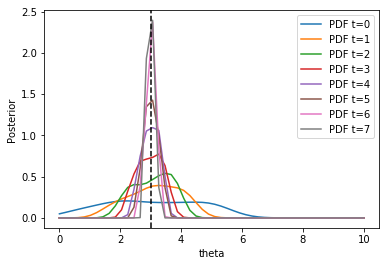

In [3]:
fig, ax = pyplot.subplots()
for t in range(history1.max_t + 1):
    df, w = history1.get_distribution(m=0, t=t)
    pyabc.visualization.plot_kde_1d(df, w, xmin=0, xmax=10,
                                   x='theta', ax=ax,
                                   label="PDF t={}".format(t))
ax.axvline(theta_true, color='k', linestyle='dashed')
ax.legend()
pyplot.show()

Second, we consider an adaptive Euclidean distance:

In [4]:
distance = pyabc.WeightedPNormDistance(p=2, adaptive=True)

abc = pyabc.ABCSMC(model, prior, distance)
db_path = "sqlite:///" + os.path.join(tempfile.gettempdir(), "as2.db")
abc.new(db_path, observation)
history2 = abc.run(minimum_epsilon=.1, max_nr_populations=8)

DEBUG:DistanceFunction:update distance function weights = {'ss1': 0.38658931227612114, 'ss2': 1.3021422720272184}
INFO:Epsilon:initial epsilon is 1.829831176310476
INFO:History:Start <ABCSMC(id=10, start_time=2018-03-08 14:02:56.780826, end_time=None)>
INFO:ABC:t:0 eps:1.829831176310476
DEBUG:DistanceFunction:update distance function weights = {'ss1': 0.3930822975686334, 'ss2': 1.445282826067481}
INFO:ABC:t:1 eps:1.1533149720259703
DEBUG:DistanceFunction:update distance function weights = {'ss1': 0.6913396865041929, 'ss2': 1.6927302541671816}
INFO:ABC:t:2 eps:1.1847957927665882
DEBUG:DistanceFunction:update distance function weights = {'ss1': 0.832853134240786, 'ss2': 1.5190770862131464}
INFO:ABC:t:3 eps:0.9080756866894336
DEBUG:DistanceFunction:update distance function weights = {'ss1': 1.3670695837574491, 'ss2': 1.4181838904886184}
INFO:ABC:t:4 eps:0.8138878790101505
DEBUG:DistanceFunction:update distance function weights = {'ss1': 2.037922046697495, 'ss2': 1.553433109581153}
INFO:AB

Let us visualize the results for the adaptive distance:

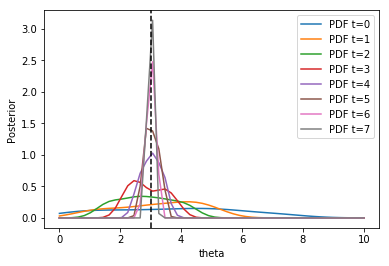

In [5]:
fig, ax = pyplot.subplots()
for t in range(history2.max_t + 1):
    df, w = history2.get_distribution(m=0, t=t)
    pyabc.visualization.plot_kde_1d(df, w, xmin=0, xmax=10,
                                   x='theta', ax=ax,
                                   label="PDF t={}".format(t))
ax.axvline(theta_true, color='k', linestyle='dashed')
ax.legend()
pyplot.show()

We observe a slightly different result. The densitities tend to be narrower around the true parameter $\theta=3$. In the debug output of abc.run, it can be seen how the weights evolve over time.